In [8]:
import sys
if ".." not in sys.path:
    sys.path.insert(0, "..")

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from cobra.io import read_sbml_model

old_model = read_sbml_model("../model/Rpom_05__biocyc__v1.xml")
biocyc_model = read_sbml_model("../model/Rpom_05.xml")

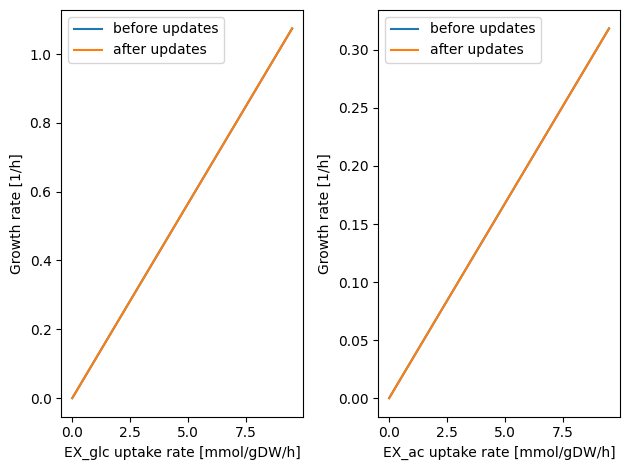

In [10]:
# Plot growth rate vs. glucose uptake rate for both models

fig, axs = plt.subplots(1, 2)

for ax, substrate in zip(axs, ["EX_glc", "EX_ac"]):
    for which, model in [("before updates", old_model), ("after updates", biocyc_model)]:
        exchange = model.reactions.get_by_id(substrate)

        growth_rate = []
        uptake = []
        for bound in np.arange(0, 10, 0.5):
            with model:
                exchange.lower_bound = -bound
                sol = model.optimize()
            growth_rate.append(sol.objective_value)
            uptake.append(bound)
        ax.plot(uptake, growth_rate, label=which)

    ax.set_xlabel(f"{substrate} uptake rate [mmol/gDW/h]")
    ax.set_ylabel("Growth rate [1/h]")
    ax.legend()

fig.tight_layout()

In [ ]:
# Find reactions that support flux when no carbon is available
with biocyc_model:
    biocyc_model.reactions.EX_glc.lower_bound = 0
    biocyc_model.reactions.EX_ac.lower_bound = 0

    sol = biocyc_model.optimize()
    fluxes = sol.fluxes
    print(f"Objective value: {sol.objective_value}")

print("Fluxes with no carbon available:")
df = fluxes.reset_index(name="flux")
df["abs_flux"] = df["flux"].abs()
df = df[df["abs_flux"] > 1e-6]
df["reaction"] = df["index"].apply(lambda x: biocyc_model.reactions.get_by_id(x).reaction)
df["from biocyc"] = df["index"].apply(lambda x: "source" in biocyc_model.reactions.get_by_id(x).notes)
df.sort_values("abs_flux", ascending=False).head(30)

Objective value: 0.0
Fluxes with no carbon available:


,index,flux,abs_flux,reaction,from biocyc


In [12]:
new_problem_reactions = ["RXN-12902", "2.1.1.21-RXN", "GLUTAMATE--METHYLAMINE-LIGASE-RXN"]

for rxn in new_problem_reactions:
    rxn = biocyc_model.reactions.get_by_id(rxn)
    print(f"Reaction {rxn.id} ({rxn.reaction})")

Reaction RXN-12902 (N5-METHYLGLUTAMINE[c] + WATER[c] --> AMMONIUM[c] + CPD-404[c])
Reaction 2.1.1.21-RXN (GLT[c] + METHYLAMINE[c] <=> AMMONIUM[c] + CPD-404[c])
Reaction GLUTAMATE--METHYLAMINE-LIGASE-RXN (ATP[c] + GLT[c] + METHYLAMINE[c] --> ADP[c] + N5-METHYLGLUTAMINE[c] + PROTON[c] + Pi[c])


In [ ]:
from collections import Counter
c = Counter()
for rxn in biocyc_model.reactions:
    c.update(list(rxn.notes.keys()))
c

Counter({'stem': 1394,
         'EC Number': 990,
         'Kegg ID': 811,
         'pathways': 705,
         'source': 418,
         'sbo': 3})

In [20]:
# Find new reactions with highest flux
biocyc_model.reactions.get_by_id("GLYC3PDEHYDROG-RXN")

Reaction identifier,GLYC3PDEHYDROG-RXN
Name,
Memory address,0x7f5b709c8740
Stoichiometry,GLYCEROL-3P[c] + UBIQUINONE-8[c] --> CPD-9956[c] + DIHYDROXY-ACETONE-PHOSPHATE[c] sn-glycerol 3-phosphate + ubiquinone-8 --> ubiquinol-8 + glycerone phosphate
GPR,SPO_RS03695
Lower bound,0.0
Upper bound,1000.0


In [4]:
with biocyc_model:
    ex_ac = biocyc_model.reactions.get_by_id("EX_ac")
    ex_ac.lower_bound = -2.5
    sol = biocyc_model.optimize()
    fluxes = sol.fluxes

for _, (rxn, abs_flux) in fluxes.abs().sort_values(ascending=False).head(10).reset_index().iterrows():
    print(f"{rxn}\t{fluxes[rxn]:.2f}\t{biocyc_model.reactions.get_by_id(rxn).reaction}")

RXN3O-5293	67.34	NADP[c] + Stearoyl-ACPs[c] <=> NADPH[c] + Octadec-2-enoyl-ACPs[c] + PROTON[c]
RXN-9635	67.34	NADH[c] + Octadec-2-enoyl-ACPs[c] + PROTON[c] --> NAD[c] + Stearoyl-ACPs[c]
BRANCHED-CHAINAMINOTRANSFERVAL-RXN	47.88	2-KETO-ISOVALERATE[c] + GLT[c] --> 2-KETOGLUTARATE[c] + VAL[c]
VALINE-PYRUVATE-AMINOTRANSFER-RXN	47.58	PYRUVATE[c] + VAL[c] --> 2-KETO-ISOVALERATE[c] + L-ALPHA-ALANINE[c]
ALANINE-DEHYDROGENASE-RXN	47.22	L-ALPHA-ALANINE[c] + NAD[c] + WATER[c] --> AMMONIUM[c] + NADH[c] + PROTON[c] + PYRUVATE[c]
ASPARTASE-RXN	-44.42	L-ASPARTATE[c] <=> AMMONIUM[c] + FUM[c]
RXN-14970	-43.94	CPD-9958[c] + FUM[c] <-- SUC[c] + UBIQUINONE-10[c]
ASPAMINOTRANS-RXN	42.74	2-KETOGLUTARATE[c] + L-ASPARTATE[c] <=> GLT[c] + OXALACETIC_ACID[c]
1.10.2.2-RXN	39.89	CPD-9958[c] + 2.0 Cytochromes-C-Oxidized[p] --> 2.0 Cytochromes-C-Reduced[p] + 2.0 PROTON[c] + UBIQUINONE-10[c]
PDH	35.79	CO-A[c] + NAD[c] + PYRUVATE[c] --> ACETYL-COA[c] + CARBON-DIOXIDE[c] + NADH[c]


In [14]:
# There is probably a cheaper way of making NADH in the new model (see notes)
with biocyc_model:
    ex_ac = biocyc_model.reactions.get_by_id("EX_ac")
    ex_ac.lower_bound = -2.5
    sol = biocyc_model.optimize()
    fluxes = sol.fluxes

    s = biocyc_model.metabolites.get_by_id("NADH[c]").summary().producing_flux.sort_values(by="percent", ascending=False).head(10)
s


,flux,reaction,percent
2OXOGLUTARATEDEH-RXN,9.455932,2OXOGLUTARATEDEH-RXN,0.277458
1.4.1.21-RXN-L-ASPARTATE/NAD/WATER//OXALACETIC_ACID/AMMONIUM/NADH/PROTON.60.,8.864848,1.4.1.21-RXN-L-ASPARTATE/NAD/WATER//OXALACETIC...,0.260115
GLUTAMATE-DEHYDROGENASE-RXN,4.462397,GLUTAMATE-DEHYDROGENASE-RXN,0.130937
1.2.1.2-RXN,3.842893,1.2.1.2-RXN,0.112759
PGLYCDEHYDROG-RXN,2.829954,PGLYCDEHYDROG-RXN,0.083037
PDH,1.915132,PDH,0.056194
GCVMULTI-RXN,1.873754,GCVMULTI-RXN,0.054980
RXN-13158,0.319513,RXN-13158,0.009375
RXN-7745,0.206041,RXN-7745,0.006046
RXN-8001,0.134375,RXN-8001,0.003943


In [17]:
biocyc_model.reactions.get_by_id("2OXOGLUTARATEDEH-RXN")

Reaction identifier,2OXOGLUTARATEDEH-RXN
Name,2OXOGLUTARATEDEH-RXN
Memory address,0x7f5b71327ef0
Stoichiometry,2-KETOGLUTARATE[c] + CO-A[c] + NAD[c] --> CARBON-DIOXIDE[c] + NADH[c] + SUC-COA[c] 2-oxoglutarate + coenzyme A + NAD+ --> CO2 + NADH + succinyl-CoA
GPR,SPO_RS01745
Lower bound,0.0
Upper bound,1000.0


In [15]:
with old_model:
    ex_ac = old_model.reactions.get_by_id("EX_ac")
    ex_ac.lower_bound = -10

    # atpm = old_model.reactions.get_by_id("ATPM")
    # atpm.bounds = (25, 25)

    sol = old_model.optimize()
    fluxes_old = sol.fluxes
    s = old_model.metabolites.get_by_id("NADH[c]").summary().producing_flux.sort_values(by="percent", ascending=False).head(10)
s
# sol.objective_value
# for _, (rxn, abs_flux) in fluxes_old.abs().sort_values(ascending=False).head(20).reset_index().iterrows():
#     print(f"{rxn}\t{fluxes_old[rxn]:.2f}\t{old_model.reactions.get_by_id(rxn).reaction}")

,flux,reaction,percent
PDH,9.881129,PDH,0.565595
MALATE-DEH-RXN,6.113071,MALATE-DEH-RXN,0.349912
PGLYCDEHYDROG-RXN,0.508609,PGLYCDEHYDROG-RXN,0.029113
1.2.1.2-RXN,0.447063,1.2.1.2-RXN,0.025590
GCVMULTI-RXN,0.208566,GCVMULTI-RXN,0.011938
AMINOBUTDEHYDROG-RXN,0.114510,AMINOBUTDEHYDROG-RXN,0.006555
RXN-13158,0.100259,RXN-13158,0.005739
RXN-8001,0.042165,RXN-8001,0.002414
PREPHENATEDEHYDROG-RXN,0.030687,PREPHENATEDEHYDROG-RXN,0.001757
IMP-DEHYDROG-RXN,0.023735,IMP-DEHYDROG-RXN,0.001359


In [6]:
old_model.reactions.get_by_id("PDH")

Reaction identifier,PDH
Name,Pyruvate dehydrogenase (NADH)
Memory address,0x7f5b7175a930
Stoichiometry,CO-A[c] + NAD[c] + PYRUVATE[c] --> ACETYL-COA[c] + CARBON-DIOXIDE[c] + NADH[c] coenzyme A + NAD+ + pyruvate --> acetyl-CoA + CO2 + NADH
GPR,
Lower bound,0.0
Upper bound,1000.0


In [7]:
fluxes_old[["RXN3O-5293", "RXN-9635"]]

RXN3O-5293    0.0
RXN-9635      0.0
Name: fluxes, dtype: float64

,flux,reaction,percent
2OXOGLUTARATEDEH-RXN,10.560211,2OXOGLUTARATEDEH-RXN,0.320275
1.4.1.21-RXN-L-ASPARTATE/NAD/WATER//OXALACETIC_ACID/AMMONIUM/NADH/PROTON.60.,7.539590,1.4.1.21-RXN-L-ASPARTATE/NAD/WATER//OXALACETIC...,0.228664
GLUTAMATE-DEHYDROGENASE-RXN,7.019025,GLUTAMATE-DEHYDROGENASE-RXN,0.212876
PDH,4.011245,PDH,0.121655
PGLYCDEHYDROG-RXN,1.444416,PGLYCDEHYDROG-RXN,0.043807
1.2.1.2-RXN,1.073847,1.2.1.2-RXN,0.032568
GCVMULTI-RXN,0.489284,GCVMULTI-RXN,0.014839
RXN-13158,0.319156,RXN-13158,0.009680
RXN-7745,0.205811,RXN-7745,0.006242
RXN-8001,0.134225,RXN-8001,0.004071


In [9]:
fluxes.abs().sort_values(ascending=False)

RXN3O-5293                            67.335174
RXN-9635                              67.335174
BRANCHED-CHAINAMINOTRANSFERVAL-RXN    47.881979
VALINE-PYRUVATE-AMINOTRANSFER-RXN     47.581876
ALANINE-DEHYDROGENASE-RXN             47.216009
                                        ...    
RXN-16011                              0.000000
RXN-16010                              0.000000
RXN-15941                              0.000000
RXN-15891                              0.000000
RXN-16136                              0.000000
Name: fluxes, Length: 2386, dtype: float64

In [10]:
exchange_fluxes = fluxes.filter(regex="EX_")
exchange_fluxes.abs().sort_values(ascending=False).head(10)

EX_co2    27.698111
EX_h2o    20.503467
EX_o2     20.000000
EX_h      16.715284
EX_nh4     3.864727
EX_ac      2.500000
EX_pi      0.380159
EX_so4     0.178325
EX_k       0.166589
EX_mg2     0.007404
Name: fluxes, dtype: float64

In [11]:
from utils.cobra_utils import widest_path, draw_path

co2_e = biocyc_model.metabolites.get_by_id("CARBON-DIOXIDE[e]")
co2_c = biocyc_model.metabolites.get_by_id("CARBON-DIOXIDE[p]")
path = widest_path(fluxes, co2_e, co2_c)
draw_path(path)

AttributeError: 'NoneType' object has no attribute 'is_directed'